# 'Assessment Capacities Project'(ACAPS)

In [23]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [24]:
df = pd.read_csv("ACAPS.csv").convert_dtypes()

### Rows and columns in the dataset

In [25]:
rows, columns = df.shape
print(f"Rows: {rows}, Columns: {columns}")

Rows: 58725, Columns: 6


In [26]:
df['date'] = pd.to_datetime(df['yearmon'], errors='coerce').dt.date
df = df.convert_dtypes()
df = df.set_index(['date']).sort_index()
df = df.drop(columns=['yearmon'])

### Sample data and features 

In [27]:
df.tail().T

date,2025-03-01,2025-03-01,2025-03-01,2025-03-01,2025-03-01
iso3,BLZ,TUV,ZMB,TUN,ZWE
region_code,LAC,EAP,SSA,MNA,SSA
pop,411106.0,9816.0,20723965.0,12200431.0,16340822.0
ACAPS_risk_level,<NA>,<NA>,<NA>,<NA>,<NA>
ACAPS_risk_title,<NA>,<NA>,<NA>,<NA>,<NA>


### Data structure, data types, and non-null counts

In [28]:
df.info

<bound method DataFrame.info of            iso3 region_code         pop  ACAPS_risk_level ACAPS_risk_title
date                                                                      
1989-01-01  AFG         SAR  11874088.0              <NA>             <NA>
1989-01-01  PSE         MNA        <NA>              <NA>             <NA>
1989-01-01  GAB         SSA    957138.0              <NA>             <NA>
1989-01-01  ARM         ECA   3443100.0              <NA>             <NA>
1989-01-01  BEN         SSA   5121657.0              <NA>             <NA>
...         ...         ...         ...               ...              ...
2025-03-01  BLZ         LAC    411106.0              <NA>             <NA>
2025-03-01  TUV         EAP      9816.0              <NA>             <NA>
2025-03-01  ZMB         SSA  20723965.0              <NA>             <NA>
2025-03-01  TUN         MNA  12200431.0              <NA>             <NA>
2025-03-01  ZWE         SSA  16340822.0              <NA>           

### Descriptive statistics of categorical columns

In [29]:
df.describe(include='string').T

,count,unique,top,freq
iso3,58725,135,AFG,435
region_code,58725,6,SSA,20445
ACAPS_risk_title,150,125,A new locust invasion in eastern Africa worsen...,6


### Descriptive statistics of numerical columns

In [30]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
pop,58713.0,41259533.486332,153319719.021372,8662.0,2108617.0,8303151.0,25698326.0,1438069596.0
ACAPS_risk_level,150.0,2.313333,0.519895,1.0,2.0,2.0,3.0,3.0


### Deatils of missing values in the features

In [31]:
total_rows = len(df)
missing_count = df.isnull().sum()
missing_percent = (missing_count / total_rows * 100).round(2)
missing_df = pd.DataFrame({'Missing Count': missing_count, 'Missing Percentage (%)': missing_percent})
missing_df = missing_df.sort_values(by='Missing Percentage (%)', ascending=False)
missing_df

,Missing Count,Missing Percentage (%)
ACAPS_risk_title,58575,99.74
ACAPS_risk_level,58575,99.74
pop,12,0.02
iso3,0,0.00
region_code,0,0.00


In [32]:
# Step 1: Create missing summary
total_rows = len(df)
missing_count = df.isnull().sum()
missing_percent = (missing_count / total_rows * 100).round(2)

missing_df = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percentage (%)': missing_percent
}).sort_values(by='Missing Percentage (%)', ascending=False)

# Step 2: Drop columns with >70% overall missing AND >20% missing in last 5 years of the data
for col in missing_df.index:
    if missing_percent[col] > 70:
        if 'date' in df.columns and pd.api.types.is_datetime64_any_dtype(df['date']):
            max_date = df['date'].max()
            five_years_ago = max_date - pd.DateOffset(years=5)
            recent_df = df[df['date'] >= five_years_ago]
            recent_missing = recent_df[col].isnull().sum()
            recent_total = recent_df[col].shape[0]
            if recent_total == 0 or (recent_missing / recent_total * 100) > 20:
                df = df.drop(columns=[col])
        else:
            df = df.drop(columns=[col])  # Drop if no date context

# Step 3: Extract clean numeric data
numeric_df = df.select_dtypes(include=['number'])
numeric_df = numeric_df.replace([np.inf, -np.inf], np.nan)
numeric_df = numeric_df.dropna(axis=1, how='all')  # Drop all-NaN columns
numeric_df = numeric_df.dropna(axis=0, how='any')  # Drop rows with any NaN


In [33]:
missing_by_iso3 = df.groupby('iso3').count()
missing_by_month = df.groupby('date').count()

### Availibility of data based on country

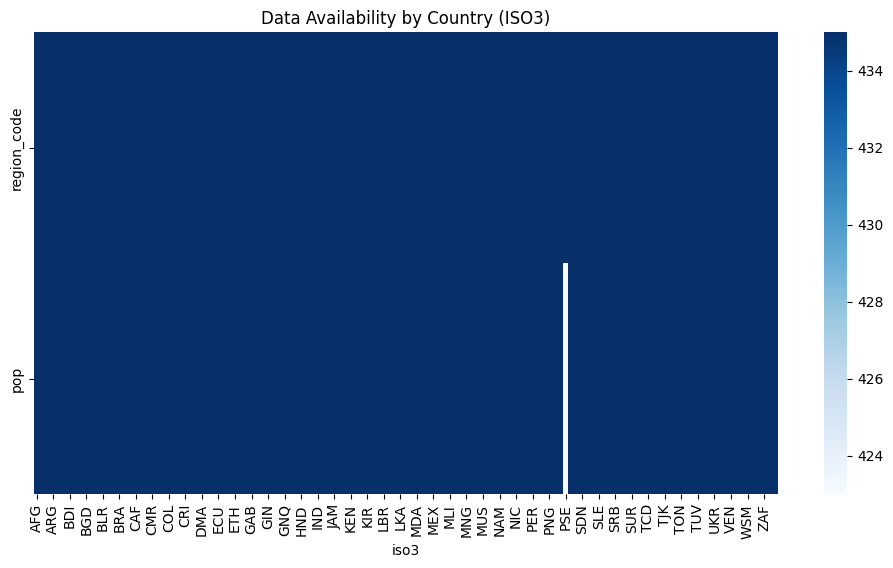

In [34]:
plt.figure(figsize=(12, 6))
sns.heatmap(missing_by_iso3.astype(float).T, cmap='Blues')
plt.title('Data Availability by Country (ISO3)')
plt.show()

### Availability of data by month

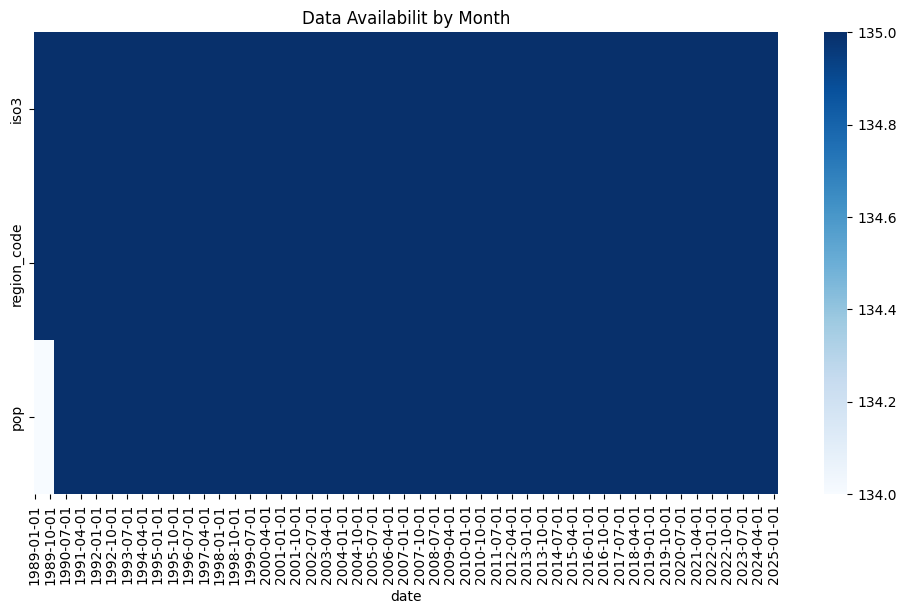

In [35]:
plt.figure(figsize=(12, 6))
sns.heatmap(missing_by_month.astype(float).T, cmap='Blues')
plt.title('Data Availabilit by Month')
plt.show()

In [36]:
#Correlation Matrix
correlation_matrix_df = numeric_df.corr(method='pearson')

In [37]:
correlation_matrix_df

,pop
pop,1.0


### Correlation between features 

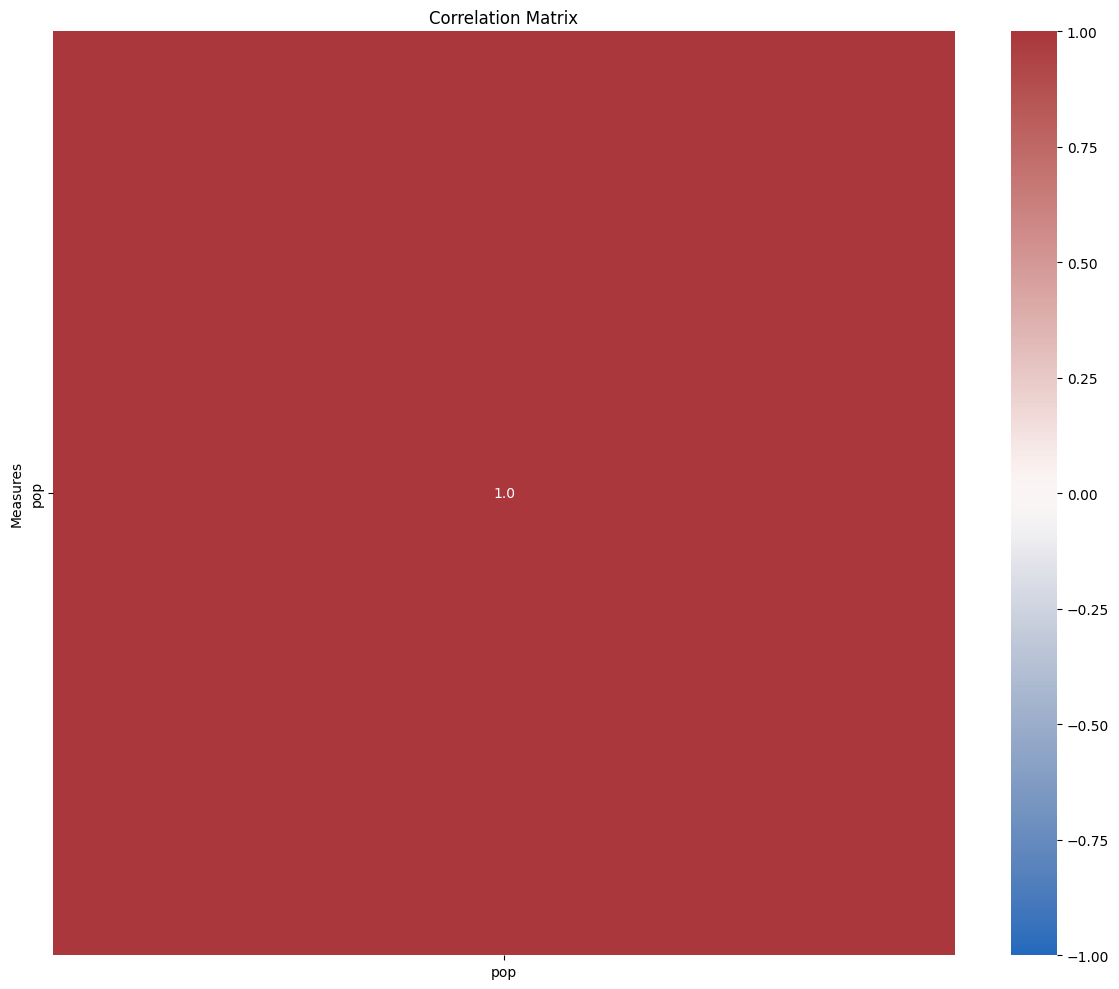

In [38]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_df, cmap='vlag', vmin=-1, vmax=1, annot=True, fmt=".1f")
plt.title('Correlation Matrix')
plt.ylabel('Measures')
plt.tight_layout()
plt.show()

In [39]:
# Extract upper triangle of correlation matrix without the diagonal
corr_matrix = correlation_matrix_df.copy()
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
filtered_corr = corr_matrix.where(mask)

# Stack and filter for |correlation| > 0.5
tidy_corr = (
    filtered_corr.stack()
    .reset_index()
    .rename(columns={'level_0': 'Variable 1', 'level_1': 'Variable 2', 0: 'Correlation'})
)
tidy_corr = tidy_corr[(tidy_corr['Correlation'] > 0.5) | (tidy_corr['Correlation'] < -0.5)]
if not tidy_corr.empty:
    tidy_corr.to_excel("ACAPS_correlations_filtered.xlsx", index=False)
    print("✅ Correlation pairs saved to ACAPS_correlations_filtered.xlsx")
else:
    print("⚠️ No correlation pairs above 0.5 or below -0.5 were found.")

# Add source column
source='ACAPS'
tidy_corr.insert(0, 'Source', source)

# Save to Excel
tidy_corr.to_excel(f"{source}_correlations_filtered.xlsx", index=False)

print(f"✅ Correlation pairs saved to {source}_correlations_filtered.xlsx")


⚠️ No correlation pairs above 0.5 or below -0.5 were found.
✅ Correlation pairs saved to ACAPS_correlations_filtered.xlsx


#### Since both the columns (indicators) are dropped, further analysis is not possible. Note: The columns are dropped because missing perecentage for each is approx. 99%